## GLORYs Surface and Bottom Temperature Processing for Northeast US Survey Strata

Processing zonal timeseries of surface and bottom temperatures from the GLORYs ocean reanalysis product.

In [1]:

####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = f"{box_path}RES_Data/GLORYs/NE_Shelf_TempSal/"
local_poly_paths = "../local_data/Shapefiles/"

# glorys_path = "../GLORYS_data/"
fpaths_glorys = os.listdir(glorys_path)

In [2]:
# Check files are there
#os.listdir("../GLORYS_data")
fpaths_glorys[0:6]

['CMEMS_Northeast_TempSal_2011_02.nc',
 'CMEMS_Northeast_TempSal_2022_01.nc',
 'CMEMS_Northeast_TempSal_1997_11.nc',
 'CMEMS_Northeast_TempSal_1999_12.nc',
 'CMEMS_Northeast_TempSal_1995_05.nc',
 'CMEMS_Northeast_TempSal_2008_12.nc']

In [3]:
# Open one file to get depth indices
glorys_single = xr.open_mfdataset(f"{glorys_path}{fpaths_glorys[0]}", combine = "by_coords", parallel = True)
glorys_single

<xarray.Dataset> Size: 508MB
Dimensions:    (depth: 38, latitude: 132, longitude: 226, time: 28)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 224B 2011-02-01 2011-02-02 ... 2011-02-28
Data variables:
    thetao     (time, depth, latitude, longitude) float64 254MB dask.array<chunksize=(28, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 254MB dask.array<chunksize=(28, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

In [6]:
# # What should each of the lists look like for loops below?
# # Load Inshore masks
# inshore_path = f"{lobecol_path}inshore_areas/"
# inshore_areas = os.listdir(inshore_path)
# inshore_names = []
# inshore_polys = []
# for area in inshore_areas:
#     inshore_names.append(area.removesuffix(".geojson"))
#     inshore_polys.append(gpd.read_file(f"{inshore_path}{area}"))

<Axes: >

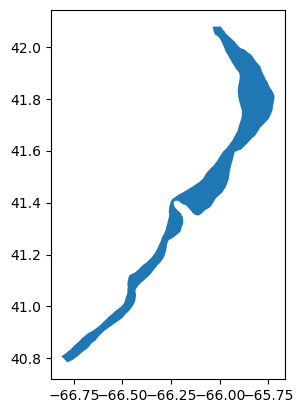

In [19]:
# Load Shapefiles
lobster_areas = gpd.read_file(f"{local_poly_paths}/LobsterStrata_StatUnion.shp")
# lobster_areas

# Create a dictionary of the independent GeoDataFrames for each polygon
gdf = lobster_areas
strata_poly_dict = {str(row['STRATA']) : gpd.GeoDataFrame([row], columns = gdf.columns, crs=gdf.crs) for _, row in gdf.iterrows()}

# # Plot one
strata_poly_dict["1170"].plot()

# Pull Surface and Bottom Out of everything

The following function will take an xarray dataset with some arguments and identify the maximum depth dimension index that holds non-NA values of some variable. These indices can then be used to extract values at those depths, which should correspond with "bottom" values. 


In [20]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    bottom_400 = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = bottom_400[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(bottom_400[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = bottom_400[y_coord].dims[0]
        dims1 = bottom_400[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(bottom_400[dims1].values)):
        for j in range(len(bottom_400[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind


In [21]:
# Load all of the Glorys year as one file

# Load GLORYs
fpaths_glorys_full = []
for file in fpaths_glorys:
    fpaths_glorys_full.append(f"{glorys_path}{file}")
# fpaths_glorys_full[0:6]

# # Lazy-load the data itself using xr.open_mfdataset
glorys_all = xr.open_mfdataset(fpaths_glorys_full, combine = "by_coords", parallel = True)
glorys_all

<xarray.Dataset> Size: 205GB
Dimensions:    (time: 11322, depth: 38, latitude: 132, longitude: 226)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude  (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time       (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 103GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 103GB dask.array<chunksize=(31, 38, 132, 226), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.1

## Get Indices for "Bottom" Layer

Use that to pull the proper depth slices from the full array.

In [22]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord = 'longitude', 
    y_coord = 'latitude', 
    depth_coord = 'depth', 
    maxDepth = 1600)

## Pull the Data at the "Bottom" Indices Across Time

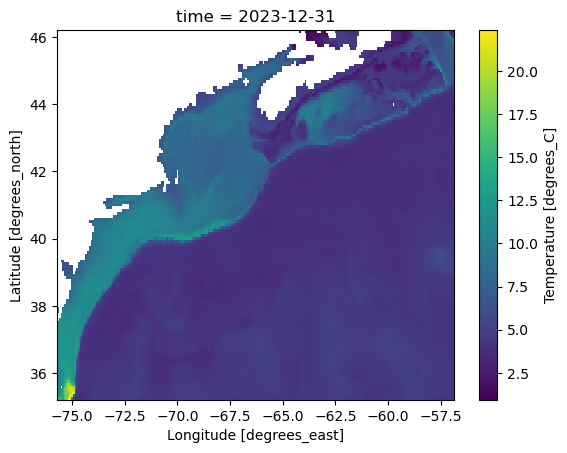

In [23]:
# Use that to extract the variables we care about

# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

### TESTING: Mask Values where Depth was* Greater than Max Depth

The Glorys data was downloaded to a max depth of 1500m. So the indices returned in the previous step are returning true bottom layer indices for areas shallower than 1500m, but for areas deeper than this it is returning a "false bottom" of 1500m.

This was never sorted out, what we did instead is change the shapefile to only cover depths shallower than 1500m.

In [24]:
# Get/Make Mask?
# masked_depth = glorys_single.thetao.where(glorys_single.depth >= 1500, np.nan)


### Prepare xr.Datasets for Region Masking

Just reorganizing and renaming variables so that they can be joined easily later.

In [25]:
# Refocus/Reshape
surface_ds = glorys_all.thetao.isel(depth = 0).to_dataset().rename_vars({"thetao" : "surface_temp"})
bottom_ds = ds.rename_vars({"thetao" : "bottom_temp"})
bottom_ds

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 132, longitude: 226, time: 11322)
Coordinates:
    depth        (latitude, longitude) float32 119kB 7.93 7.93 ... 55.76 55.76
  * latitude     (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
  * longitude    (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * time         (time) datetime64[ns] 91kB 1993-01-01 1993-01-02 ... 2023-12-31
Data variables:
    bottom_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(31, 132, 226), meta=np.ndarray>

# Cropping to the Inshore Areas, Reshape as Timeseries

From here we can loop through the inshore areas and mask out their values. The following function will perform regional masking of an xarray dataset for a target variable, returning a pandas dataframe.

In [26]:
# Function to mask
def calc_ts_mask(grid_obj, shp_obj, shp_name, var_name = "sst"):
  """
  Return a timeseries using data that falls within shapefile. 
  
  Standard deviation
  not included so that this function can be used for any period of time.
  
  Args:
    grid_obj       : xr.Dataset of the desired input data to mask
    shp_obj        : shapefile polygon to use as a mask
    shp_name (str) : String to use as name when making mask
    var_name (str) : Optional string identifying the variable to use
    climatology (bool): Whether you are masking a climatology, informs naming conventions and
    whether to process standard deviation
  """

  #### 1. Make the mask
  area_mask = regionmask.Regions(
    shp_obj.geometry,
    name = shp_name)

  #### 2. Mask the array with gom_mask to get nan test
  # mask = area_mask.mask(grid_obj, lon_name = "longitude", lat_name = "latitude")
  mask = area_mask.mask(grid_obj["longitude"], grid_obj["latitude"])

  #### 3. Extract data that falls within the mask
  masked_ds = grid_obj.where(~np.isnan(mask))

  #### 4. Calculate timeseries mean

  # Not area-weighted
  masked_ts = getattr(masked_ds, var_name).mean(dim = ("latitude", "longitude"))

  #### 5. Change time index rownames to a column 

  # Convert to Timeseries Dataframe
  masked_ts_df = masked_ts.to_dataframe()
  masked_ts_df = masked_ts_df.reset_index()[["time", f"{var_name}"]]
    
  # Return the table as output
  return masked_ts_df

## Perform Masking on Each Polygon

The following code will loop through the regions and process regional means of surface and bottom temperatures.

In [44]:
# list to store the inshore region timeseries
strata_ts = []  # list for timeseries
strata_names = [] # list for names

# Iterate through names and shapes simultaneously
#for mask_shp, mask_name in zip(strata_polys, strata_names):
for mask_name, mask_shp in strata_poly_dict.items():
    
    #### 1. Get masked Timeseries of surface temperature
    masked_sst = calc_ts_mask(
        grid_obj = surface_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "surface_temp")

    #### 2. Get masked Timeseries of bottom temperature
    masked_bt = calc_ts_mask(
        grid_obj = bottom_ds, 
        shp_obj  = mask_shp, 
        shp_name = mask_name,
        var_name = "bottom_temp")
    
    #### 3. Merge on time
    
    # Merge
    regional_timeline = masked_sst.merge(masked_bt, how = "left", on = "time")

    #Set index as the date, drop time
    regional_timeline.index = regional_timeline.index = regional_timeline["time"]
    regional_timeline       = regional_timeline.drop(["time"], axis = 1)

    # Reset Index
    regional_timeline = regional_timeline.reset_index()
    
    # Add to list
    strata_names.append(mask_name)
    strata_ts.append(regional_timeline)
    
    print(f"{mask_name} timeseries processed.")

1360 timeseries processed.
1400 timeseries processed.
1270 timeseries processed.
1260 timeseries processed.
1280 timeseries processed.
3660 timeseries processed.
3650 timeseries processed.
1290 timeseries processed.
1300 timeseries processed.
1240 timeseries processed.
1220 timeseries processed.
1210 timeseries processed.
3610 timeseries processed.
3590 timeseries processed.
3600 timeseries processed.
1200 timeseries processed.
1180 timeseries processed.
1170 timeseries processed.
1160 timeseries processed.
1190 timeseries processed.
1230 timeseries processed.
1250 timeseries processed.
3550 timeseries processed.
3450 timeseries processed.
3460 timeseries processed.
1050 timeseries processed.
1090 timeseries processed.
1130 timeseries processed.
1100 timeseries processed.
1060 timeseries processed.
1140 timeseries processed.
1150 timeseries processed.
1010 timeseries processed.
1020 timeseries processed.
1070 timeseries processed.
1110 timeseries processed.
1120 timeseries processed.
1

In [46]:
# Check one
print(strata_names[0])
strata_ts[0].head()

1360


,time,surface_temp,bottom_temp
0,1993-01-01,6.329306,7.886219
1,1993-01-02,6.242183,7.888454
2,1993-01-03,6.066458,7.887558
3,1993-01-04,6.065010,7.886760
4,1993-01-05,6.222965,7.894338


<Axes: xlabel='time'>

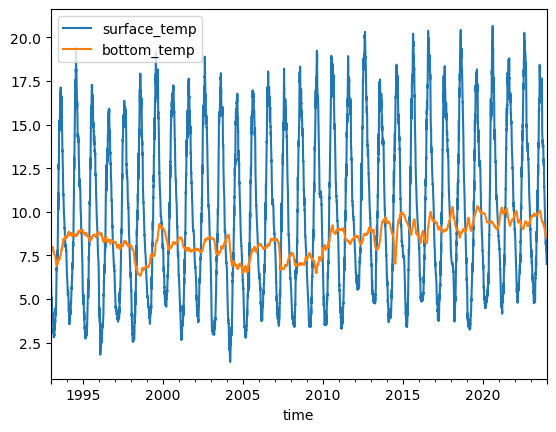

In [47]:
strata_ts[0].plot("time")

## What Does the Entire Area Resemble?

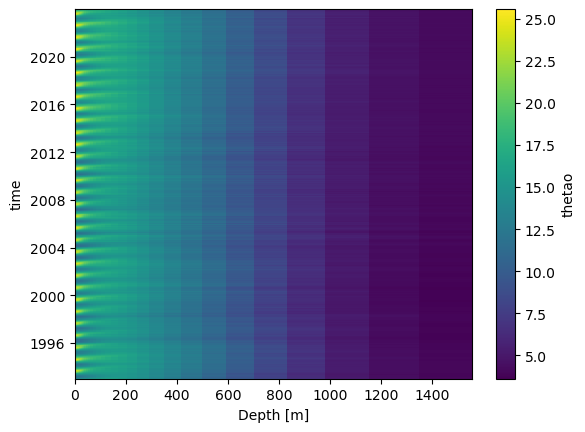

In [48]:
# This looks so weird/cool...
#  glorys_all.thetao.mean(dim = ("longitude", "latitude")).plot()
# glorys_all.time

# Save timeseries for Inspection

In [51]:
# Save Inshore Data Locally
for strata_temps, strata_name in zip(strata_ts, strata_names):
    #os.listdir("../local_data")
    strata_temps.to_csv(f"../local_data/lobster_strata_timeseries/GLORYs_surfbottemp_{strata_name}.csv")

